# Part3. 가설 설정과 가설 검증을 위한 데이터 분석

## 가설 세워보기
- Social 과 Referral 채널에는 마케팅 투자를 해도 구매전환율이 크게 변화하지 않을 것이다.  (1~3월 구매전환율 큰 변화 없음)
    
    --> 구매전환율은 유입 채널에 영향을 받지 않을 것이다.
    
- 해당 사이트는 남성 고객을 타겟으로 하는 사이트로 보인다. 남성 제품의 유입 및 구매가 항상 제일 많을 것이다.
- 남성 제품으로 유입되는 고객은 display 채널을 통해서 주로 유입될 것이다. (Men's 세션과 Display의 상관관계)
- 남성 outerwear의 판매는 계절의 영향을 받는다. / 반면 여성 outerwear의 판매는 계절의 영향을 받지 않는다.
- 여성 제품으로 유입되는 고객은 Referral 채널을 통해서 유입된다. (Women's 세션과 Referral 상관관계)
- 키즈 제품과 여성 제품의 traffic trend가 비슷하게 흐름 
    
    --> 키즈 제품과 여성 제품의 유입에는 양의 상관관계가 있을 것이다.
    
    --> 상관관계가 있는 게 맞다면, 앞으로 이 사이트는 프로모션 시 여성 및 키즈 제품 구매 고객(여성고객으로 추정)을 주요 대상으로 보는 것이 좋다.
    
- device + men / women : 구매전환율 비교
- 코호트 분석을 통한 재구매 횟수의 분포/평균 등을 확인 --> 재구매 횟수에 따라 잠재고객 그룹을 분류하여 프로모션 적용 여부를 결정하는 방법도 생각해볼 수 있다.

In [10]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy import stats
from numpy import mean
import pickle
import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
from matplotlib import gridspec
%matplotlib inline

import pydata_google_auth
from google.cloud import bigquery
credentials = pydata_google_auth.get_user_credentials(
  ['https://www.googleapis.com/auth/bigquery'],
)

project_name= 'project_name'
client = bigquery.Client (project = project_name , credentials = credentials) 

pd.options.display.float_format = '{:.5f}'.format

In [3]:
path = "local_path"
ga_data = pd.read_pickle(f"{path}/ga_sample_170101_170331.pkl")

In [4]:
ga_data['month'] = ga_data['date'].apply(lambda x: datetime.strptime(x,'%Y%m%d').month)

### 가설1. Referral과 Social 유입채널에서의 구매전환율은 기간 변화에 관계없이 stable할 것이다.
    -> stable함이 밝혀지면? 

#### 1) 가설 생성의 배경

In [5]:
df1 = ga_data.groupby(['channelGrouping','month','isImpression']).agg({'SessionId':'nunique'})
df2 = ga_data.groupby(['channelGrouping','month']).agg({'SessionId':'nunique'})

In [17]:
display(df1.head(2))
display(df2.head(2))

,,,SessionId
channelGrouping,month,isImpression,
(Other),1,impression,1
Affiliates,1,e-commerce,134


,,SessionId
channelGrouping,month,
(Other),1,1
Affiliates,1,445


In [6]:
df = pd.merge(df1.reset_index().rename(columns = {'SessionId':'session_cnt_split'}),
df2.reset_index().rename(columns = {'SessionId':'session_cnt_total'}),
        on = ['channelGrouping','month'],how='left')

df = df.assign(cvr = round(df['session_cnt_split'] / df['session_cnt_total'],4))
df.loc[df['isImpression'] == 'impression','cvr'] = 0

In [7]:
# Sort the DataFrame, if necessary.
channel_cvr = df[df['isImpression'] == 'e-commerce'].sort_values(['channelGrouping', 'month'])

# Use groupby and pcnt_change on the 'quantity' column.
channel_cvr['change_pct_point'] = channel_cvr.groupby('channelGrouping')['cvr'].diff()

In [29]:
channel_cvr[channel_cvr['channelGrouping'].isin(['Referral','Social'])]

,channelGrouping,month,isImpression,session_cnt_split,session_cnt_total,cvr,change_pct_point
31,Referral,1,e-commerce,1770,4469,0.39610,NaN
33,Referral,2,e-commerce,1595,4268,0.37370,-0.02240
35,Referral,3,e-commerce,1819,4622,0.39360,0.01990
37,Social,1,e-commerce,434,2687,0.16150,NaN
39,Social,2,e-commerce,541,3007,0.17990,0.01840
41,Social,3,e-commerce,518,2725,0.19010,0.01020


In [48]:
channel_cvr

,channelGrouping,month,isImpression,session_cnt_split,session_cnt_total,cvr,change_pct_point
1,Affiliates,1,e-commerce,134,445,0.30110,NaN
3,Affiliates,2,e-commerce,124,463,0.26780,-0.03330
5,Affiliates,3,e-commerce,148,503,0.29420,0.02640
7,Direct,1,e-commerce,1846,6545,0.28200,NaN
9,Direct,2,e-commerce,1596,5907,0.27020,-0.01180
11,Direct,3,e-commerce,1568,6176,0.25390,-0.01630
13,Display,1,e-commerce,168,403,0.41690,NaN
15,Display,2,e-commerce,110,318,0.34590,-0.07100
17,Display,3,e-commerce,109,331,0.32930,-0.01660
19,Organic Search,1,e-commerce,4982,18744,0.26580,NaN


- Referral 은 CVR 37~ 39%, Social은 CVR 16~ 19%으로, 구매전환율의 추이가 다른 채널에 비해 stable한 편으로 보입니다.

Text(0.5, 0, 'MONTH')

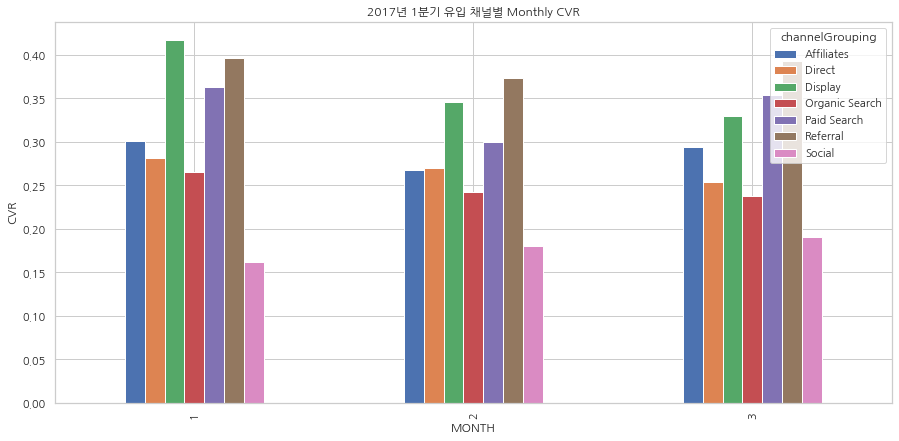

In [8]:
ax = pd.pivot_table(data=channel_cvr, values='cvr',columns='channelGrouping',index='month',aggfunc='sum')\
.plot(kind='bar',figsize=(15,7))
ax.set_title('2017년 1분기 유입 채널별 Monthly CVR')
ax.set_ylabel("CVR")
ax.set_xlabel("MONTH")

Text(0.5, 0, 'MONTH')

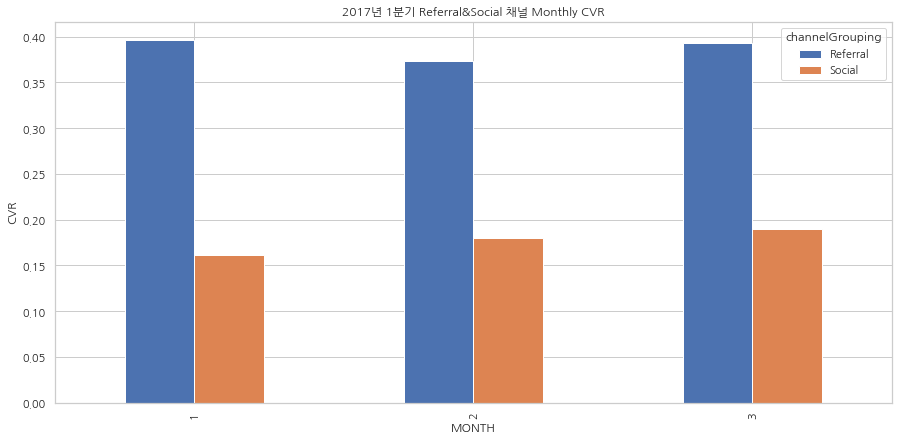

In [9]:
ax = pd.pivot_table(data=channel_cvr[channel_cvr['channelGrouping'].isin(['Referral','Social'])], values='cvr',columns='channelGrouping',index='month',aggfunc='sum')\
.plot(kind='bar',figsize=(15,7))
ax.set_title('2017년 1분기 Referral&Social 채널 Monthly CVR')
ax.set_ylabel("CVR")
ax.set_xlabel("MONTH")

#### 2) 가설 검증 Plan
- 사용 데이터 : 2017년도 4월 ~ 12월 데이터의 유입 채널별 월별 유입 및 구매 수 데이터
- 각 채널별 월별 구매전환율의 변화를 확인합니다. (table 및 Trend 시각화)

In [13]:
import time
# Query 문 -- 기초 Source SQL code를 view로 저장하여 사용하였습니다.
s_date = '20170101'
e_date = '20170731'

s_time = time.time()
query = f"""
select channelGrouping, extract(month from parse_date('%Y%m%d', date)) as month,
count(distinct SessionId) as session_cnt
from `ga_sample.ga_sample_2017`
where 1=1
and date between "{s_date}" and "{e_date}"
group by channelGrouping, extract(month from parse_date('%Y%m%d', date))
"""
channel_monthly_total = client.query(query).to_dataframe()
print(time.time()-s_time)

s_time = time.time()
query = f"""
select channelGrouping, extract(month from parse_date('%Y%m%d', date)) as month,
count(distinct SessionId) as session_cnt
from `ga_sample.ga_sample_2017`
where 1=1
and date between "{s_date}" and "{e_date}"
and isImpression = 'e-commerce'
group by channelGrouping, extract(month from parse_date('%Y%m%d', date))
"""
channel_monthly_buy = client.query(query).to_dataframe()
print(time.time()-s_time)

- 데이터가 17년도 8월까지 있는 것으로 확인, 8월도 31일 전체일수의 데이터가 있는 것이 아니기 때문에 7월 데이터까지만 검증에 활용하였습니다.

In [27]:
display(channel_monthly_total.head(2))
display(channel_monthly_buy.head(2))

,channelGrouping,month,session_cnt
0,Direct,4,7605
1,Paid Search,4,834


,channelGrouping,month,session_cnt
0,Organic Search,6,4941
1,Social,4,483


In [6]:
channel_monthly_buy = channel_monthly_buy.rename(columns = {'session_cnt':'buy_session_cnt'})

In [7]:
channel_cvr = pd.merge(channel_monthly_total, channel_monthly_buy, on = ['channelGrouping','month'],how='outer')

In [30]:
#channel_cvr = channel_cvr[channel_cvr['channelGrouping'].isin(['Social','Referral'])].sort_values(['channelGrouping','month'])

In [8]:
channel_cvr = channel_cvr.sort_values('month')

In [9]:
#channel_cvr = channel_cvr[channel_cvr['month'] != 8]
channel_cvr = channel_cvr.assign(cvr = round(channel_cvr['buy_session_cnt'] / channel_cvr['session_cnt'], 4))
channel_cvr = channel_cvr.sort_values('month')
channel_cvr['change_pct_point'] = channel_cvr.groupby('channelGrouping')['cvr'].diff()

In [11]:
channel_cvr[channel_cvr['channelGrouping'].isin(['Social','Referral'])].sort_values(['channelGrouping','month'])

,channelGrouping,month,session_cnt,buy_session_cnt,cvr,change_pct_point
43,Referral,1,4469,1770.00000,0.39610,NaN
2,Referral,2,4268,1595.00000,0.37370,-0.02240
18,Referral,3,4622,1819.00000,0.39360,0.01990
29,Referral,4,4741,1946.00000,0.41050,0.01690
39,Referral,5,5595,2207.00000,0.39450,-0.01600
13,Referral,6,5802,2341.00000,0.40350,0.00900
20,Referral,7,5715,2599.00000,0.45480,0.05130
44,Social,1,2687,434.00000,0.16150,NaN
25,Social,2,3007,541.00000,0.17990,0.01840
38,Social,3,2725,518.00000,0.19010,0.01020


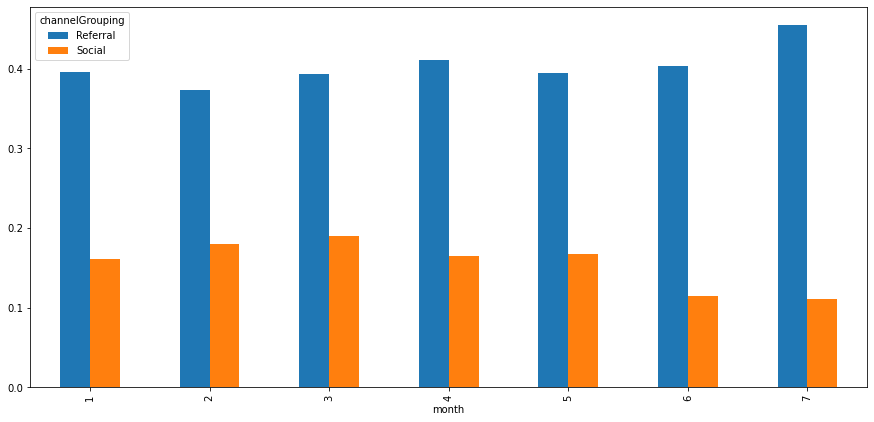

In [34]:
# 제목, 축 이름 추가하기
ax = pd.pivot_table(data=channel_cvr, values='cvr',columns='channelGrouping',index='month',aggfunc='sum')\
.plot(kind='bar',figsize=(15,7))
ax.set_title('2017년 1분기 유입 채널별 Monthly CVR')
ax.set_ylabel("CVR")
ax.set_xlabel("MONTH")

#### 3) 가설 검증 결과

- Referral 채널 구매전환율은 6월까진 stable하나 7월에 약 5%point 가량 소폭 증가하였고,
- Social 채널의 경우는 1 ~ 3월의 약 16% ~ 19% 에서 4 ~ 7월은 약 11% ~ 16% 로 구매전환율이 하락하는 추세입니다.
- Social은 특히 7월에 세션 유입이 많은데, 구매 전환율은 오히려 줄었습니다. 이 원인을 좀 더 파악하여 어느 채널에 주력하는 것이 좋은지 확인해보는 것이 좋겠습니다.

### 가설2. 남성 제품으로 유입되는 고객은 Direct 채널을 통해서 주로 유입될 것이다. (Men's 세션과 Direct의 상관관계)

#### 1) 가설 생성의 배경

channel:  Direct


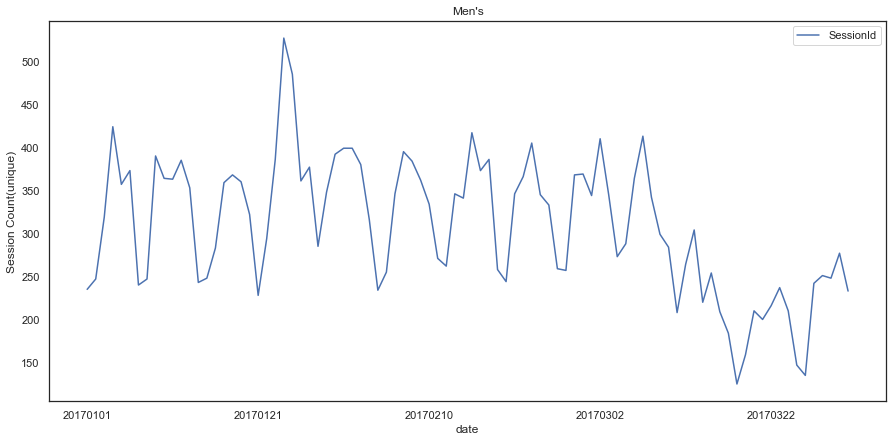

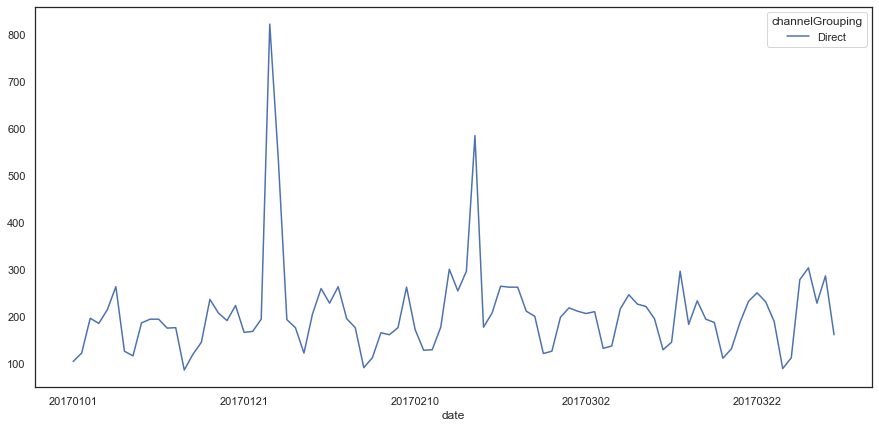

In [26]:
ax = pd.pivot_table(data=ga_data[(ga_data['v2ProductCategory'].str.contains('Men'))], \
                         values='SessionId',index='date',aggfunc='nunique').plot(figsize=(15,7))
ax.set_title("Men's")
ax.set_ylabel('Session Count(unique)')
for channel in ga_data['channelGrouping'].unique():
    if channel != 'Direct':
        continue
    #print('channel: ',channel)
    ax = pd.pivot_table(data=ga_data[ga_data['channelGrouping'] == channel], \
                       index='date',columns='channelGrouping',values='SessionId',aggfunc='nunique').plot(figsize=(15,7))
    plt.show()

# legend 변경 필요: SessionId -> Session count

- Direct 채널 traffic trend와 Men's 카테고리의 traffic trend가 비슷하게 흘러가는 것이 확인되어 위와 같은 가설을 제시하였습니다.

#### 2) 가설 검증 Plan
- 사용 데이터 : 2017년도 1월 ~ 7월 Men's 카테고리와 Direct 채널의 데이터
- Scatter Plot 시각화 + 상관관계 분석

In [12]:
# Query
import time
# Query 문
s_date = '20170101'
e_date = '20170731'

s_time = time.time()
query = f"""
select channelGrouping, parse_date('%Y%m%d', date) as date,
count(distinct SessionId) as session_cnt
from `ga_sample.ga_sample_2017`
where 1=1
and channelGrouping = 'Direct'
and date between "{s_date}" and "{e_date}"
group by channelGrouping, parse_date('%Y%m%d', date)
"""
direct_daily = client.query(query).to_dataframe()
print(time.time()-s_time)

s_time = time.time()
query = f"""
select parse_date('%Y%m%d', date) as date,
count(distinct SessionId) as session_cnt
from `ga_sample.ga_sample_2017`
where 1=1
and v2ProductCategory like "%%Men's%%"
and date between "{s_date}" and "{e_date}"
group by parse_date('%Y%m%d', date)
"""
mens_daily= client.query(query).to_dataframe()
print(time.time()-s_time)

13.042409896850586
11.360637187957764


In [15]:
mens_daily.rename(columns = {'session_cnt':'mens_session_cnt'},inplace=True)

In [17]:
direct_daily.rename(columns = {'session_cnt':'direct_session_cnt'}, inplace=True)

In [21]:
daily_df = pd.merge(direct_daily, mens_daily, on ='date',how='outer').fillna(0)

In [22]:
daily_df

,channelGrouping,date,direct_session_cnt,mens_session_cnt
0,Direct,2017-01-01,105,235
1,Direct,2017-04-09,156,240
2,Direct,2017-07-23,191,234
3,Direct,2017-06-21,208,361
4,Direct,2017-04-23,139,242
...,...,...,...,...
207,Direct,2017-05-02,357,426
208,Direct,2017-04-28,348,433
209,Direct,2017-01-30,260,392
210,Direct,2017-03-26,113,135


#### 먼저, scatter plot으로 시각화하여 direct 세션 수와 mens 세션 수의 관계를 단순하게 파악해봅니다.

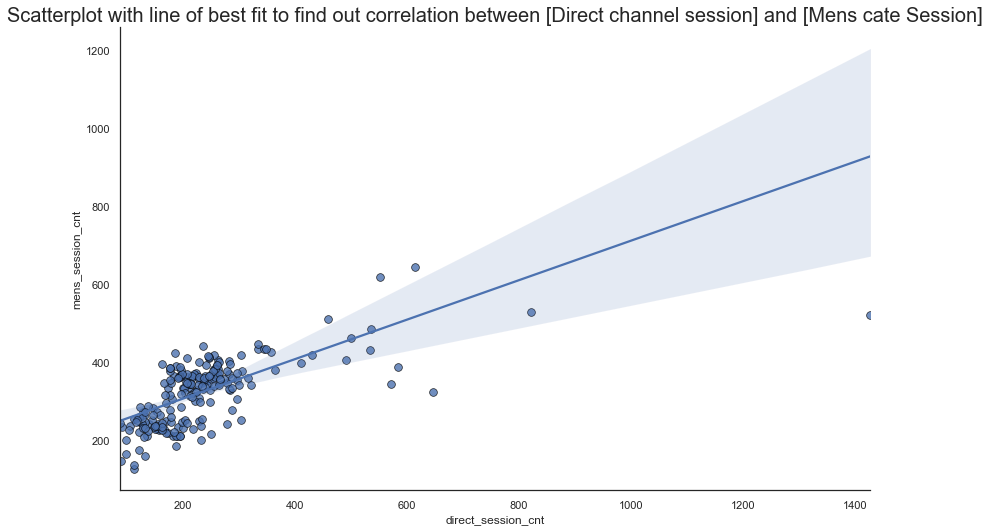

In [30]:
sns.set_style("white")
gridobj = sns.lmplot(x="direct_session_cnt", y="mens_session_cnt", data=daily_df, 
                     height=7, aspect=1.6, robust=True, palette='tab10',
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
#gridobj.set(xlim=(0.5, 7.5), ylim=(0, 50))
plt.title("Scatterplot with line of best fit to find out correlation between [Direct channel session] and [Mens cate Session]", fontsize=20)
plt.show()

- 그래프로 보았을 때에는 두 데이터가 어느 정도 **양의 상관 관계**가 있는 것으로 보입니다.

#### 상관분석 전에, 데이터의 정규성을 확인하기 위해 Shapiro-Wilk Test를 수행합니다.

In [24]:
# 정규성 확인 (정규분포를 만족하는지 확인)
direct_normality = stats.shapiro(daily_df['direct_session_cnt'])
mens_normality = stats.shapiro(daily_df['mens_session_cnt'])
print('Direct channel normality: ', direct_normality, 'Mens cate normality: ', mens_normality)

Direct channel normality:  ShapiroResult(statistic=0.6423903107643127, pvalue=7.405840112653889e-21) Mens cate normality:  ShapiroResult(statistic=0.9615209698677063, pvalue=1.6630579921184108e-05)


- direct session count 와 Mens session count 모두 p-value 가 0.05보다 한참 작은 수치입니다.
- 정규성을 만족한다고 보기 어렵습니다.
- 때문에, 데이터의 정규성을 전제로 하는 Pearson correlation은 실행하지 않고, 대신 데이터의 수치를 순위로 치환하여 상관 관계를 확인하는 Spearman 과 Kendall-Tau correlation을 실행해보았습니다.

![correlation](https://imgur.com/FmdiYoE.png)
**상관분석 진행 방법 (with stats)**

[correlation_description](https://junsik-hwang.tistory.com/37?category=803034)

In [31]:
print('< spearman corr >')
display(daily_df[['direct_session_cnt','mens_session_cnt']].corr(method='spearman'))
print(stats.spearmanr(a = daily_df['direct_session_cnt'], b = daily_df['mens_session_cnt']))
print('')
print('< kendall corr >')
display(daily_df[['direct_session_cnt','mens_session_cnt']].corr(method='kendall'))
print(stats.kendalltau(x = daily_df['direct_session_cnt'], y = daily_df['mens_session_cnt']))

< spearman corr >


,direct_session_cnt,mens_session_cnt
direct_session_cnt,1.00000,0.68673
mens_session_cnt,0.68673,1.00000


SpearmanrResult(correlation=0.6867254045599286, pvalue=6.502320613201462e-31)

< kendall corr >


,direct_session_cnt,mens_session_cnt
direct_session_cnt,1.00000,0.49486
mens_session_cnt,0.49486,1.00000


KendalltauResult(correlation=0.494857403998028, pvalue=1.373653543071442e-26)


#### 3) 가설 검증 결과
-> 스피어만 상관계수 약 0.69, 켄달 상관계수 약 0.49로, **뚜렷한 양적 상관 관계**를 보입니다! 

-> Next : 
- Direct Session의 트렌드에 맞추어, 매월 3~4주에 Men's 카테고리에 유입되는 사용자들을 타겟으로 한 프로모션 진행 테스트를 해볼 수 있습니다.
- 매월 3~4주에 위의 내용과 같은 프로모션을 하였을 때와, 그 외 기간에 프로모션을 하였을 때의 구매전환율의 차이를 확인해볼 수 있습니다. (A/B Test)

### 가설3. 남성 outerwear의 판매는 계절의 영향을 받는다.

#### 1) 가설 생성의 배경
![aparrel_catedepth3](https://imgur.com/R8P32fE.png)
- week2의 Aparrel 내의 제품 카테고리별 월별 판매 수 Trend를 확인하여 가설3.을 내용을 설정하였습니다.

#### 2) 가설 검증 Plan
- 사용 데이터 : 2017년도 1월 ~ 7월 Men's-Outerwear 카테고리와 Direct 채널의 데이터
- 계절별 판매 세션 수 시각화
- 계절별 판매 세션 수 ANOVA
    - H0: 계절에 따른 판매 세션 수의 평균 차이가 유의미하지 않다.
    - H1: 계절에 따른 판매 세션 수의 평균 차이가 유의미하다.

In [36]:
# Query
s_time = time.time()
query = f"""
with basic_set as (
select *, 
case 
when extract(month from parse_date('%Y%m%d', date)) in (1,2) then 'winter'
when extract(month from parse_date('%Y%m%d', date)) in (3,4,5) then 'spring'
when extract(month from parse_date('%Y%m%d', date)) in (6,7) then 'summer'
else 'not_set'
end as Season
from `ga_sample.ga_sample_2017`
where 1=1
and v2ProductCategory like "%%Men's-Outerwear%%"
and date between "{s_date}" and "{e_date}"
)

select Season, parse_date('%Y%m%d', date) as date, count(distinct SessionId) as session_cnt
from basic_set
where 1=1
and isImpression = 'e-commerce'
and date between "{s_date}" and "{e_date}"
group by Season, parse_date('%Y%m%d', date)
"""

season_df = client.query(query).to_dataframe()
print(time.time()-s_time)

10.598130226135254


In [38]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [41]:
group1 = season_df.loc[season_df['Season'] == 'winter','session_cnt']
group2 = season_df.loc[season_df['Season'] == 'spring','session_cnt']
group3 = season_df.loc[season_df['Season'] == 'summer','session_cnt']

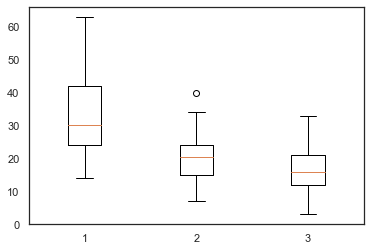

In [42]:
plot_data = [group1, group2, group3]
ax = plt.boxplot(plot_data)
plt.show()

- 1(Winter): Abnormality를 제외하더라도 정규 분포 형상을 보이지 않고, Right Skewness를 보이는 것 같습니다. 
- 2(Spring): 90% percentile을 봐도 여기는 1과 다르게 Left Skewness가 의심됩니다. 
- 3(Summer): 정규분포 형태로 추정됩니다. <br/>
    -> 현재 1번 Group과 2번 Group 간에는 등분산성을 침해하는 요소가 있는 것으로 의심되어 ANOVA모델은 적합하지 않은 것으로 보입니다.


In [14]:
# season_anova = season_df[['Season','session_cnt']]
# season_anova.sample(n=3)

#### 계절과 판매 세션 수 간의 분산분석을 실행은 등분산성 훼손으로 인해 불가능합니다. 
- 다음 Part4에서 해당 가설의 확인을 재진행할 예정입니다.

#### + 사실 "계절과 판매 세션 수의 상관관계"는 재미없는 가설로 보일 수 있습니다.
- 당연히 겨울이 지나고 아우터 매출이 감소하지 않겠어? 라는 생각을 할 수 있다는 것입니다..!
- 다음부터는 가설 설정 시에 "나의 아이디어를 다른 사람들도 흥미롭게 볼까"라는 점을 유념할 필요가 있습니다.

In [15]:
#### 적용 불가 ####
# model = ols('session_cnt ~ C(Season)', season_anova).fit()
# anova_lm(model)

In [50]:
client.close()